# MLP for HZZ4l analysis using  Keras
Authors: Javier Duarte, Thong Nguyen     
Modified: Andre Sznajder

## **Mount Google Drive**

In [12]:
!fusermount -u drive
!pip install uproot

fusermount: failed to unmount /content/drive: No such file or directory


In [13]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'Bari_Lectures/'

Mounted at /content/gdrive


#Load data using PANDAS data frames#
Now we load two different `NumPy` arrays. One corresponding to the VBF H->ZZ->4l signal and the other one corresponds to the QCD ZZ->4l background .

In [0]:
import uproot
import numpy as np
import pandas as pd
import h5py

# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

treename = 'HZZ4LeptonsAnalysisReduced'
filename = {}
upfile = {}
params = {}
df = {}

filename['VV'] = base_dir+'Data/ntuple_qqH_ZZ4mu.root'
filename['bkg'] = base_dir+'Data/ntuple_bkg_ZZ4mu.root'


# Variables from Roottree to be copyed to PANDA dataframe
VARS = ['f_lept1_pt','f_lept1_eta','f_lept1_phi', \
        'f_lept2_pt','f_lept2_eta','f_lept2_phi', \
        'f_lept3_pt','f_lept3_eta','f_lept3_phi', \
        'f_lept4_pt','f_lept4_eta','f_lept4_phi', \
        'f_jet1_pt','f_jet1_eta','f_jet1_phi', \
        'f_jet2_pt','f_jet2_eta','f_jet2_phi',\
        'f_mass4l','f_massjj','f_deltajj']
        

upfile['VV'] = uproot.open(filename['VV'])
upfile['bkg'] = uproot.open(filename['bkg'])

params['VV'] = upfile['VV'][treename].arrays(VARS)
params['bkg'] = upfile['bkg'][treename].arrays(VARS)

df['VV'] = pd.DataFrame(params['VV'],columns=VARS)
df['bkg'] = pd.DataFrame(params['bkg'],columns=VARS)

# Remove undefined variable entries VARS[i] <= -999
NDIM = len(VARS)
for i in range(NDIM):
    df['VV'] = df['VV'][(df['VV'][VARS[i]] > -999)]
    df['bkg']= df['bkg'][(df['bkg'][VARS[i]] > -999)]


# add isSignal variable
df['VV']['isSignal'] = np.ones(len(df['VV'])) 
df['bkg']['isSignal'] = np.zeros(len(df['bkg'])) 

## **Specify the number of NN input variables **

In [0]:

# Define the NN input variables 
#NVARS = len(VARS)
NVARS = len(VARS) - 3



## Define the model using KERAS functional API 
We'll start with a dense (fully-connected) NN layer.
Our model will have a single fully-connected hidden layer with the same number of neurons as input variables. 
The output layer contains a single neuron using a sigmoid activation in order to a number between 0 and 1 to make binary classification

We are using the `binary_crossentropy` loss function during training, a standard loss function for binary classification problems. 
We will optimize the model with the Adam algorithm for stochastic gradient descent and we will collect accuracy metrics while the model is trained.

In [16]:
# baseline keras model
from keras.models import Sequential, Model
from keras.optimizers import SGD, Adam
from keras.layers import Input, Activation, Dense, Dropout
from keras.utils import np_utils
from keras.layers import Lambda , concatenate
from keras import backend

def swish(x):
    return backend.sigmoid(x) * x

def crop(dimension, start, end):
    # Crops (or slices) a Tensor on a given dimension from start to end
    # example : to crop tensor x[:, :, 5:10]
    # call slice(2, 5, 10) as you want to crop on the second dimension
    def func(x):
        if dimension == 0:
            return x[start: end]
        if dimension == 1:
            return x[:, start: end]
        if dimension == 2:
            return x[:, :, start: end]
        if dimension == 3:
            return x[:, :, :, start: end]
        if dimension == 4:
            return x[:, :, :, :, start: end]
    return Lambda(func)
  
# Select the NN input variables. Using just lepton and and jets 4-mom ( low level veriables) ! 
input  = Input(shape=(NVARS,), name = 'input') 

# Slice the input into leptons and put feed first lepton layer 
input_lept = crop(1,0,11)(input)
hidden_lept = Dense(30, name = 'hidden_lept1', kernel_initializer='normal', activation=swish)(input_lept)
hidden_lept = Dense(20, name = 'hidden_lept2', kernel_initializer='normal', activation=swish)(hidden_lept)

# Slice the input into leptons and put feed first jet layer 
input_jet  = crop(1,12,17)(input)
hidden_jet = Dense(10, name = 'hidden_jet1', kernel_initializer='normal', activation=swish)(input_jet)

# Concatenate the lepton and jet layers into a single hidden layer
hidden = concatenate([hidden_lept, hidden_jet])

hidden  = Dense(20, name = 'hidden1', kernel_initializer='normal', activation=swish)(hidden)

# Define the output layer
output  = Dense(1, name = 'output', kernel_initializer='normal', activation='sigmoid')(hidden)

# create the model
model = Model(inputs=input, outputs=output)
# Define the optimizer ( minimization algorithm )
#optim = SGD(lr=0.01,decay=1e-6)
optim = Adam(lr=0.001)
# compile the model
model.compile(optimizer=optim, loss='binary_crossentropy', metrics=['accuracy'])
# print the model summary
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 18)           0                                            
__________________________________________________________________________________________________
lambda_7 (Lambda)               (None, 11)           0           input[0][0]                      
__________________________________________________________________________________________________
hidden_lept1 (Dense)            (None, 30)           360         lambda_7[0][0]                   
__________________________________________________________________________________________________
lambda_8 (Lambda)               (None, 5)            0           input[0][0]                      
__________________________________________________________________________________________________
hidden_lep

## Dividing the data into testing and training dataset

We will split the data into two parts (one for training+validation and one for testing). 


In [0]:
df_all = pd.concat([df['VV'],df['bkg']])
dataset = df_all.values
X = dataset[:,0:NDIM]
Y = dataset[:,NDIM]

from sklearn.model_selection import train_test_split
X_train_val, X_test, Y_train_val, Y_test = train_test_split(X, Y, test_size=0.2, random_state=6)

## Run NN Training 


In [23]:
# Number of training epochs
nepochs=300 
# Batch size
batch=10
# Train classifier
history = model.fit(X_train_val[:,0:NVARS], 
                    Y_train_val, 
                    epochs=nepochs, 
                    batch_size=batch, 
                    verbose=1, # switch to 1 for more verbosity 
                    validation_split=0.2)

Train on 9225 samples, validate on 2307 samples
Epoch 1/300
9225/9225 [==============================] - 1s 135us/step - loss: 0.2214 - acc: 0.9363 - val_loss: 0.1891 - val_acc: 0.9376
Epoch 2/300
9225/9225 [==============================] - 1s 132us/step - loss: 0.1537 - acc: 0.9502 - val_loss: 0.1680 - val_acc: 0.9445
Epoch 3/300
9225/9225 [==============================] - 1s 134us/step - loss: 0.1455 - acc: 0.9514 - val_loss: 0.1786 - val_acc: 0.9445
Epoch 4/300
9225/9225 [==============================] - 1s 133us/step - loss: 0.1369 - acc: 0.9511 - val_loss: 0.1561 - val_acc: 0.9458
Epoch 5/300
9225/9225 [==============================] - 1s 133us/step - loss: 0.1302 - acc: 0.9564 - val_loss: 0.1923 - val_acc: 0.9311
Epoch 6/300
9225/9225 [==============================] - 1s 132us/step - loss: 0.1263 - acc: 0.9566 - val_loss: 0.1634 - val_acc: 0.9489
Epoch 7/300
9225/9225 [==============================] - 1s 132us/step - loss: 0.1205 - acc: 0.9577 - val_loss: 0.1891 - val_acc: 

## Plot performance
Here, we plot the history of the training and the performance in a ROC curve

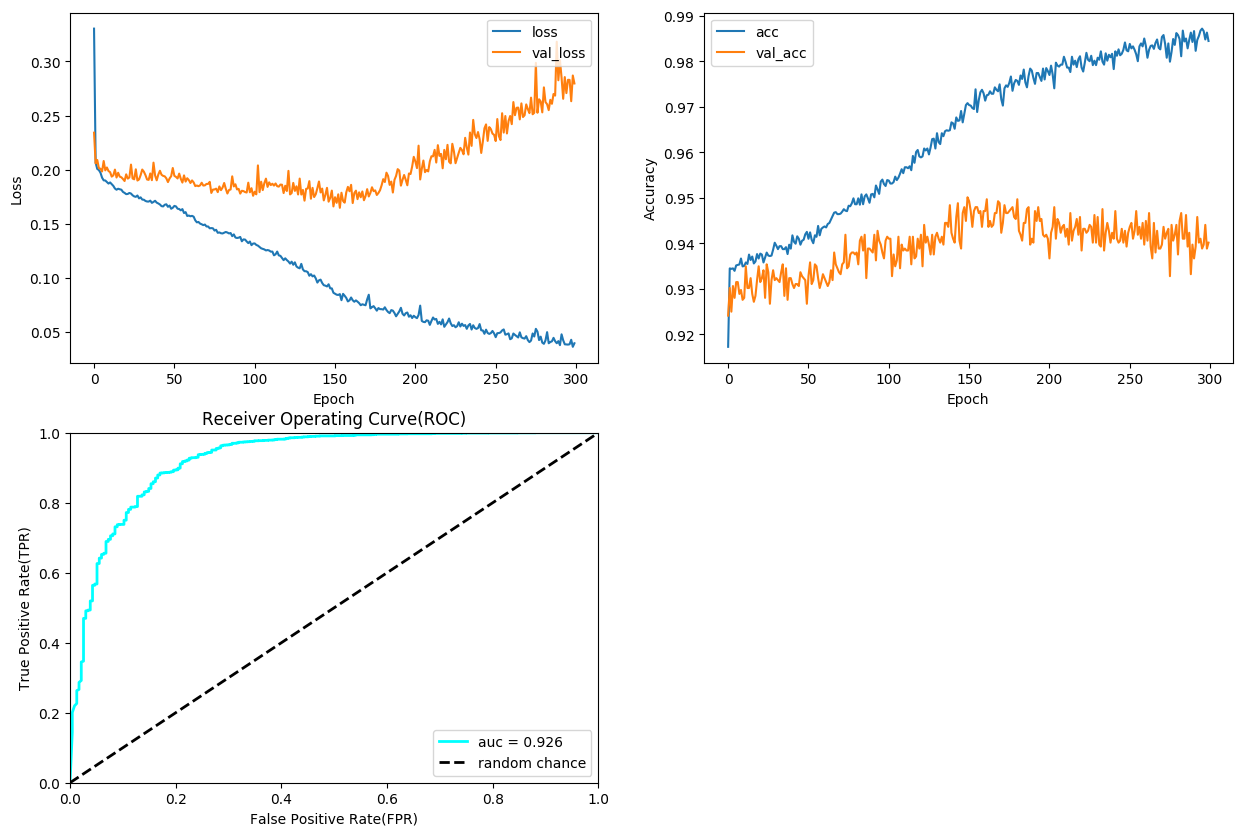

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('default')
plt.figure(figsize=(15,10))

# plot loss vs epoch
ax = plt.subplot(2, 2, 1)
ax.plot(history.history['loss'], label='loss')
ax.plot(history.history['val_loss'], label='val_loss')
ax.legend(loc="upper right")
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')

# plot accuracy vs epoch
ax = plt.subplot(2, 2, 2)
ax.plot(history.history['acc'], label='acc')
ax.plot(history.history['val_acc'], label='val_acc')
ax.legend(loc="upper left")
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')

# Plot ROC
Y_predict = model.predict(X_test[:,0:NVARS])
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(Y_test, Y_predict)
roc_auc = auc(fpr, tpr)
ax = plt.subplot(2, 2, 3)
ax.plot(fpr, tpr, lw=2, color='cyan', label='auc = %.3f' % (roc_auc))
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='k', label='random chance')
ax.set_xlim([0, 1.0])
ax.set_ylim([0, 1.0])
ax.set_xlabel('False Positive Rate(FPR)')
ax.set_ylabel('True Positive Rate(TPR)')
ax.set_title('Receiver Operating Curve(ROC)')
ax.legend(loc="lower right")
plt.show()

# Plot  $m_{jj}$, $\Delta\eta_{jj}$ and $m_{4l}$  for NN output > cut to show that the NN did learned the physics !


(50, 400)

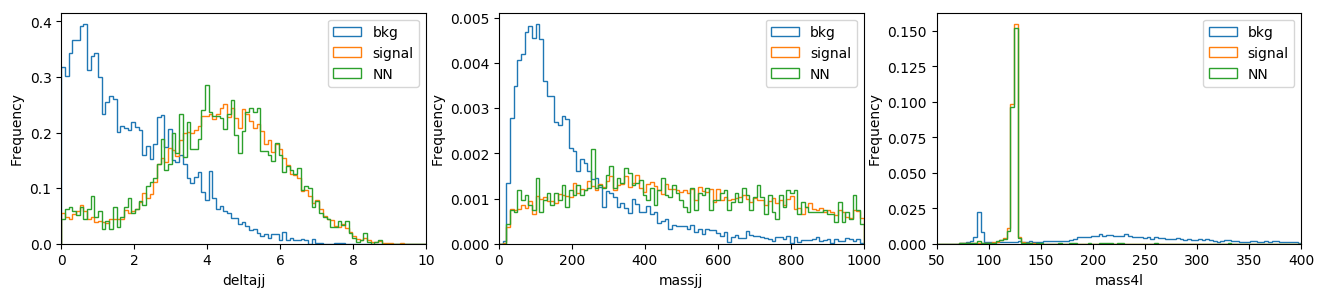

In [20]:

import matplotlib.pyplot as plt

# Define pandas dataframes the variables
VARS=['f_deltajj','f_massjj','f_mass4l']
params['VV'] = upfile['VV'][treename].arrays(VARS)
params['bkg'] = upfile['bkg'][treename].arrays(VARS)
df['VV'] = pd.DataFrame(params['VV'],columns=VARS)
df['bkg'] = pd.DataFrame(params['bkg'],columns=VARS)

# Remove events with undefined variable entries VARS[i] <= -999
N = len(VARS)
for i in range(N):
    df['VV'] = df['VV'][(df['VV'][VARS[i]] > -999)]
    df['bkg']= df['bkg'][(df['bkg'][VARS[i]] > -999)]


# Define the data frame for NN predictions and high level variables
data = pd.DataFrame({'f_mass4l':X_test[:,18],'f_massjj':X_test[:,19],'f_deltajj':X_test[:,20],'NNoutput':Y_predict[:,0]})

# Selects events with NNoutput > cut
cut = 0.5 
data = data[(data['NNoutput'] > cut)]

    
# Plot  delta_eta between jets for signal, background and NN selected events 
plt.style.use('default') # It's ugly otherwise
plt.figure(figsize=(16, 3),dpi=100)

plt.subplot(1, 3, 1)
plt.xlabel('deltajj')
bins = np.linspace(0, 10, 100)
df['bkg']['f_deltajj'].plot.hist(bins, label='bkg',histtype='step', density=1)
df['VV']['f_deltajj'].plot.hist(bins, label='signal',histtype='step', density=1)
data['f_deltajj'].plot.hist(bins, label='NN',histtype='step', density=1)
plt.legend(loc='upper right')
plt.xlim(0,10)

# Plot  dijets mass for signal, background and NN selected events 
plt.subplot(1, 3, 2)
plt.xlabel('massjj')
bins = np.linspace(0, 1000, 100)
df['bkg']['f_massjj'].plot.hist(bins, label='bkg',histtype='step', density=1)
df['VV']['f_massjj'].plot.hist(bins, label='signal',histtype='step', density=1)
data['f_massjj'].plot.hist(bins, label='NN',histtype='step', density=1)
plt.legend(loc='upper right')
plt.xlim(0,1000)

# Plot 4l invariant mass for signal, background and NN selected events 
plt.subplot(1, 3, 3)
plt.xlabel('mass4l')
bins = np.linspace(50, 400, 100)
df['bkg']['f_mass4l'].plot.hist(bins, label='bkg',histtype='step', density=1)
df['VV']['f_mass4l'].plot.hist(bins, label='signal',histtype='step', density=1)
data['f_mass4l'].plot.hist(bins, label='NN',histtype='step', density=1)
plt.legend(loc='upper right')
plt.xlim(50,400)



## **Plot Purity(Precision) versus signal Efficiency(TPR)**

In [21]:
from sklearn.metrics import precision_score

Y_predict = model.predict(X_test[:,0:NVARS], verbose=1)
cut = 0.5
predictions = np.where(Y_predict>cut, 1, 0)

precision_score(Y_test, predictions, average='binary')
print(precision_score)

report = classification_report(Y_test, predictions)
print(report)

2884/2884 [==============================] - 0s 14us/step
<function precision_score at 0x7f6a1ce09938>


NameError: ignored